In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Muscle Activation Dataset

Dataset Original Length n:  14950
Dataset Sampled Length n:  14950
../datasets/ground_truth/muscle_activation_gt.csv


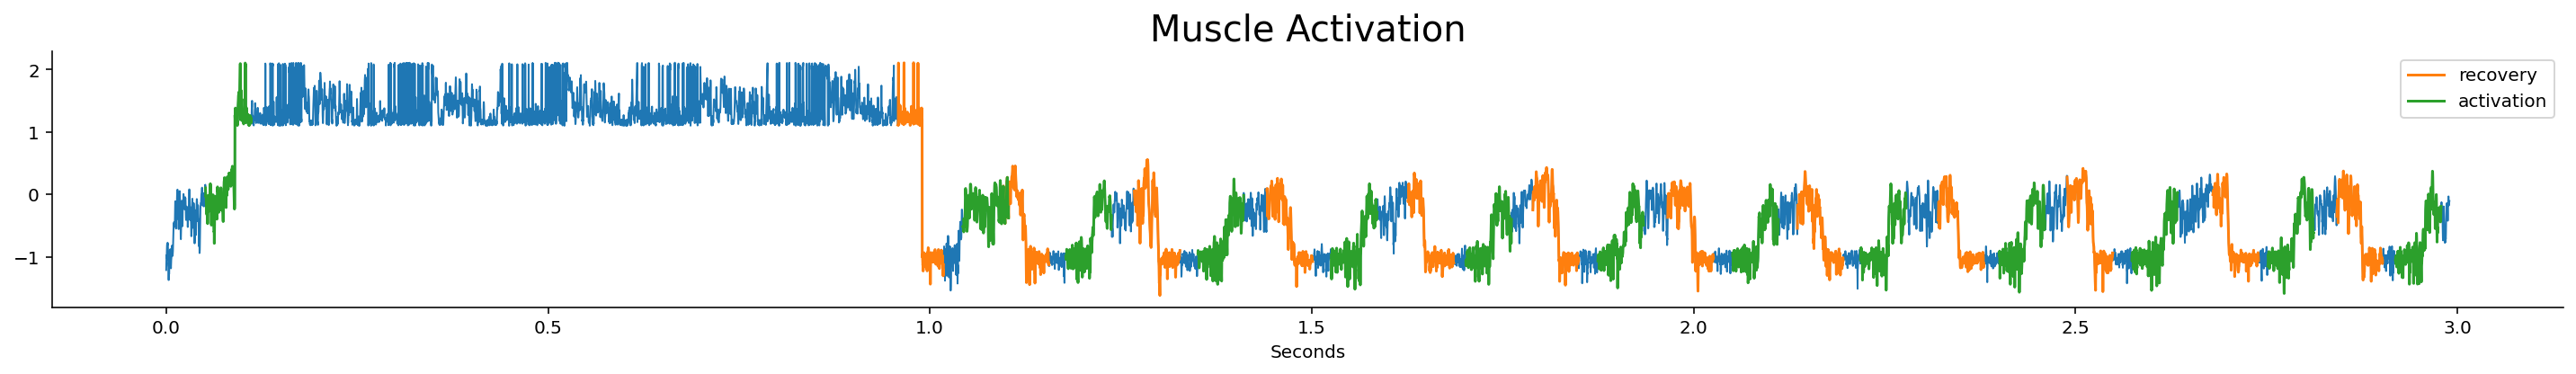

In [2]:
file = 'muscle_activation.csv'
ds_name = "Muscle Activation"
series, df_gt = ml.read_dataset_with_index(file)
data = series.values
# series = ml.as_series(data, np.arange(0, 29899, 2) / 10000, 'Seconds')
plot_dataset(file, series, ds_name=ds_name, ground_truth=df_gt)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = False
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/muscle_activation.csv


# k-Motiflets

## First, we learn the motif length l

Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.99it/s]


Motif Length: 200 	 0.04 	AU_PEF: 0.212 	#Elbows: 3


Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.35it/s]


Motif Length: 250 	 0.05 	AU_PEF: 0.212 	#Elbows: 1


Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


Motif Length: 300 	 0.06 	AU_PEF: 0.179 	#Elbows: 2


Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.98it/s]


Motif Length: 350 	 0.07 	AU_PEF: 0.185 	#Elbows: 2


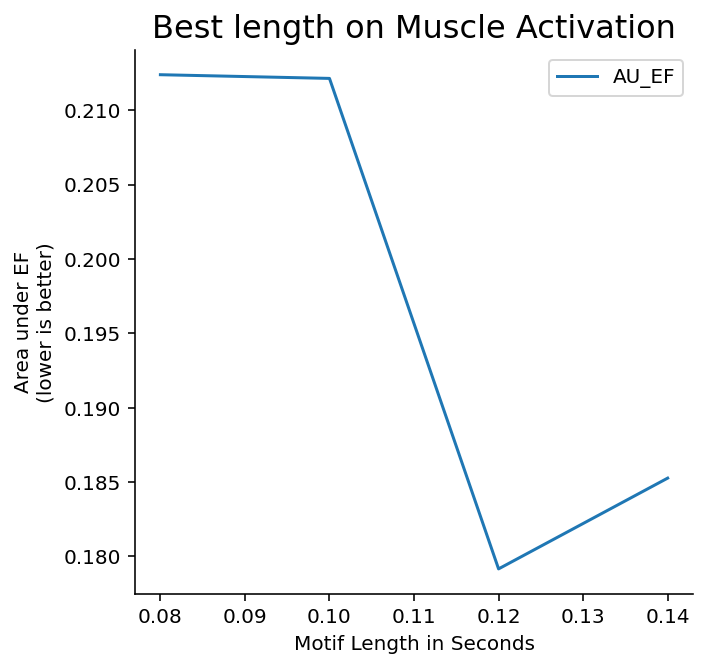

Found motif length 600


In [4]:
ks = 15
length_range = np.arange(400,701,100) 

motif_length = plot_motif_length_selection(
    ks, series, file, length_range, ds_name=ds_name)


print ("Found motif length", motif_length)

## Next, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.07it/s]


Chosen window-size: 600
Identified Elbow Points [ 9 12]
Filtered Elbow Points [12]


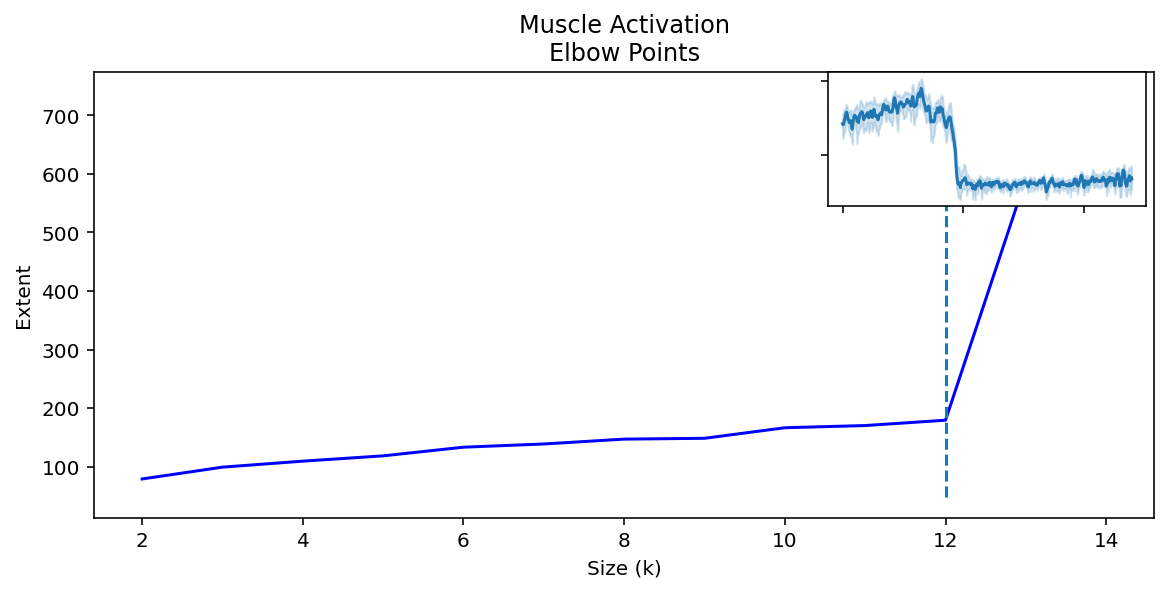

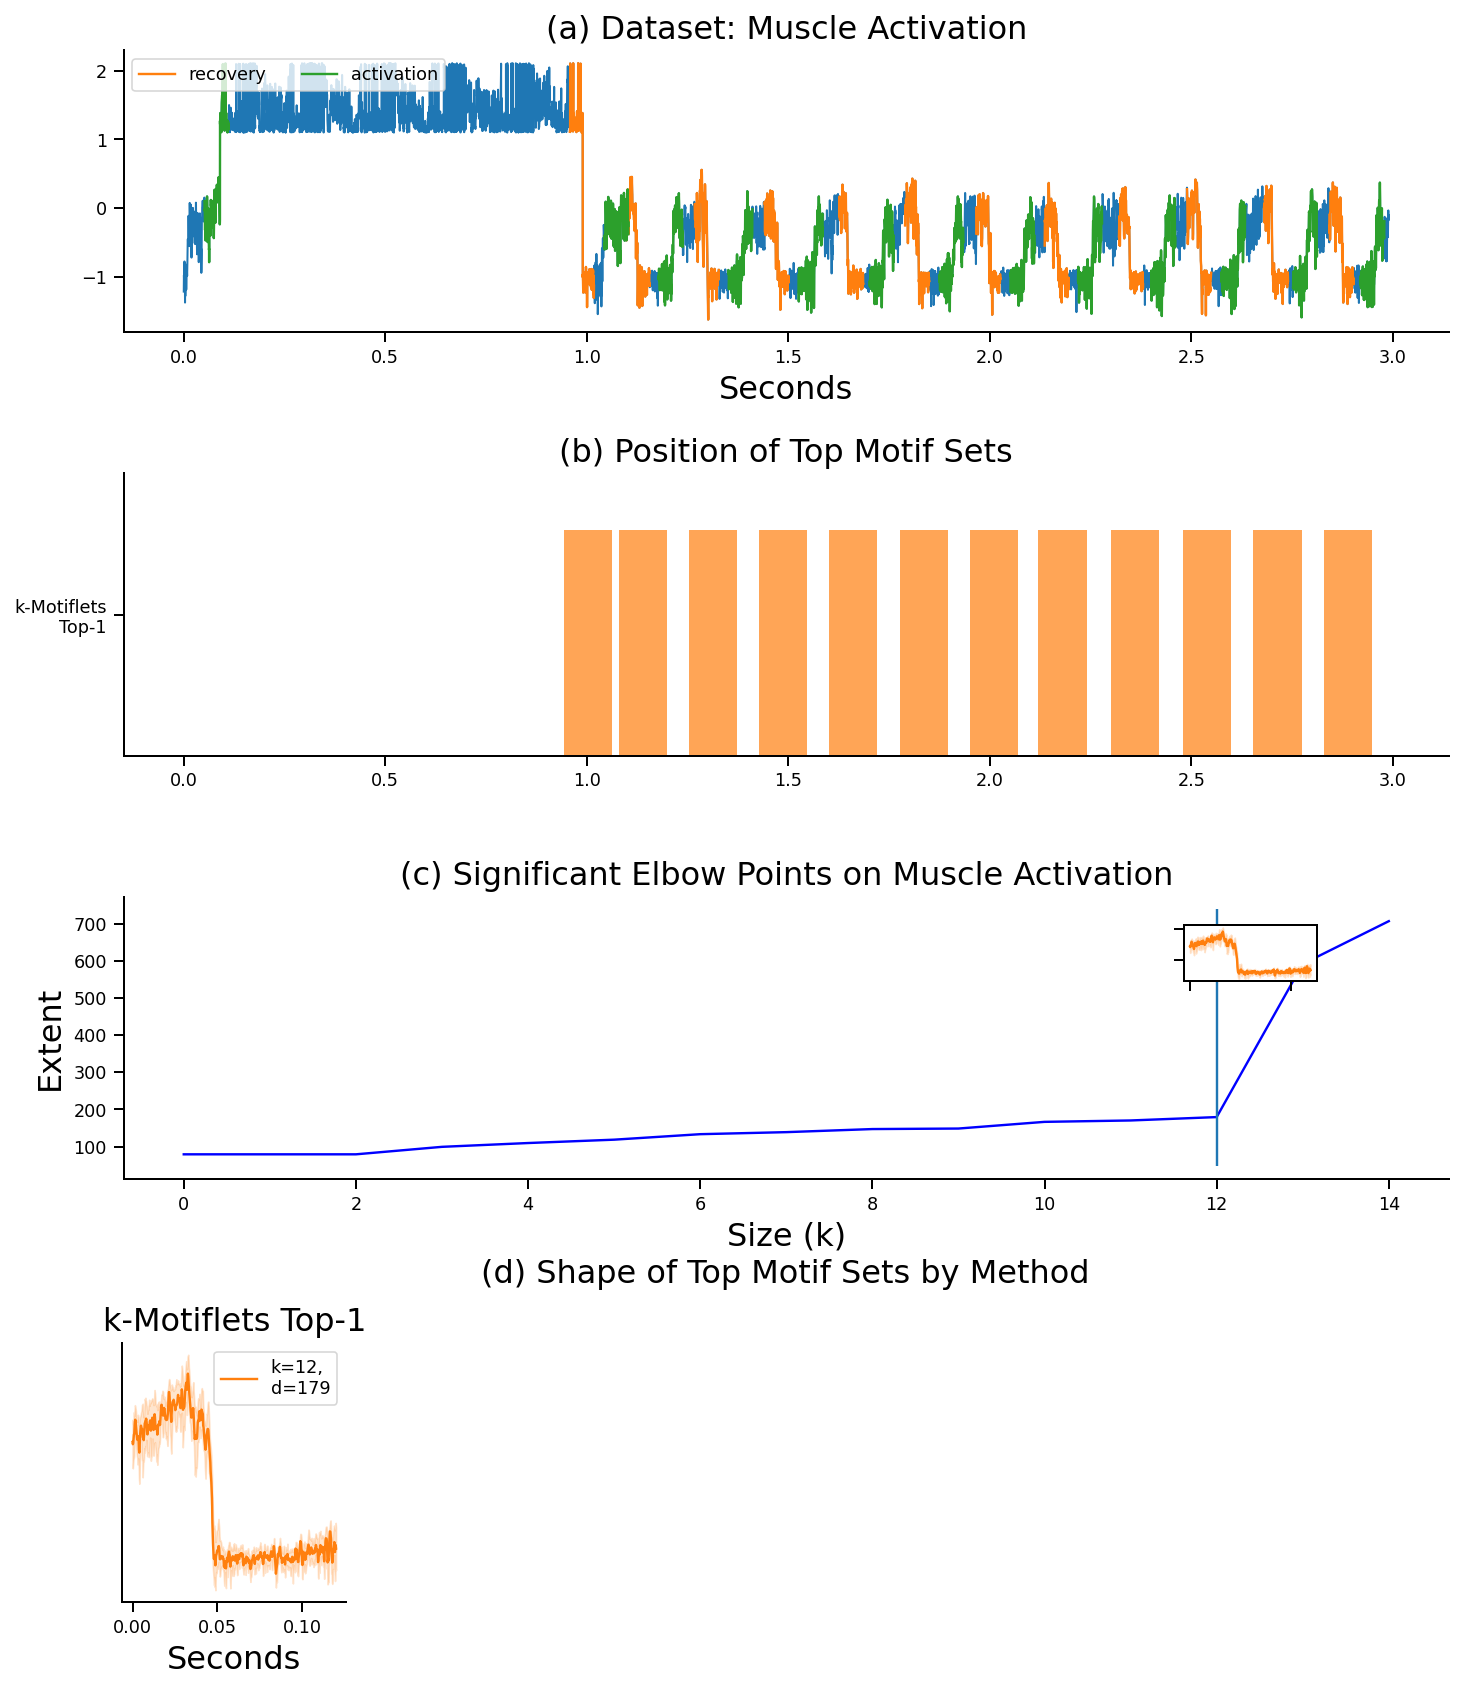

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True, 
    motif_length=motif_length, method_name="k-Motiflets", ground_truth=df_gt)

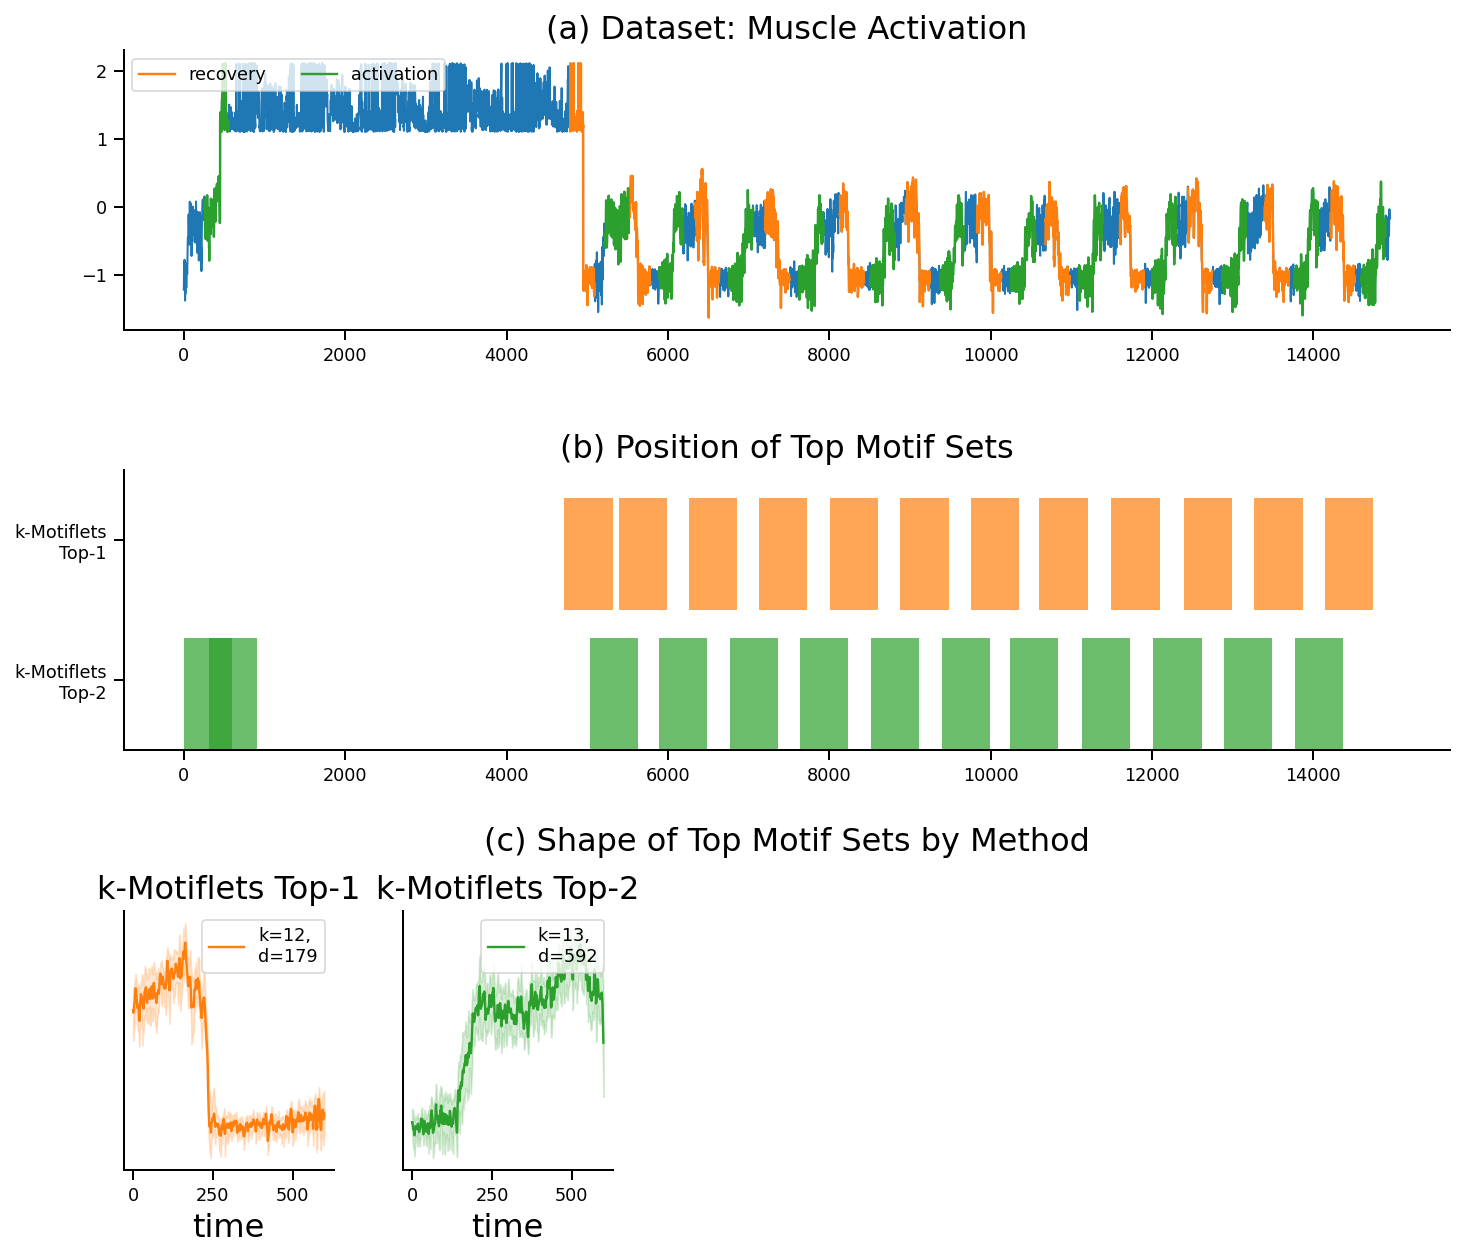

In [6]:
# 13 is no elbow point, thus we add it manually
elbow_points = [12, 13]
                
plot_grid_motiflets(
        dataset, data, motiflets, elbow_points,
        dists, motif_length, ds_name=ds_name, show_elbows=False,
        ground_truth=df_gt, method_name="k-Motiflets")

# motifset = plot_competitors(series, ds_name, motiflets, motif_length, prefix="Motiflets", ground_truth=df_gt)

In [7]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius of TOP-1 Motif", r_top1, r_top2)
print("Extent of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

radii = np.ceil([r_top2, r_top1])
print("Radii", radii)

Radius of TOP-1 Motif 400.98760986328125 153.02577209472656
Extent of TOP-1 Motif 592.0465698242188
Radii [154. 401.]


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But this oracle is off by just 11% on both parameters to reflect human trial-and-error.

In [8]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

# Human error due to trial-and-error
error = 0.11

rs = radii * (1.0*(1-error))
mls = np.int32(motif_length * (1+error))

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

print("Radii with human error\t", rs)
print("Length with human error\t", mls)

Radii r [153.02577209 400.98760986]
Best Radii	 [153.02577209 400.98760986]
Best Lengths	 600
Radii with human error	 [136.19293716 356.87897278]
Length with human error	 666


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [9]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

r: 116.04447174072266 d: 175.30995178222656
r: 291.64208984375 d: 408.121337890625
Filtered Elbow Points [0, 1]


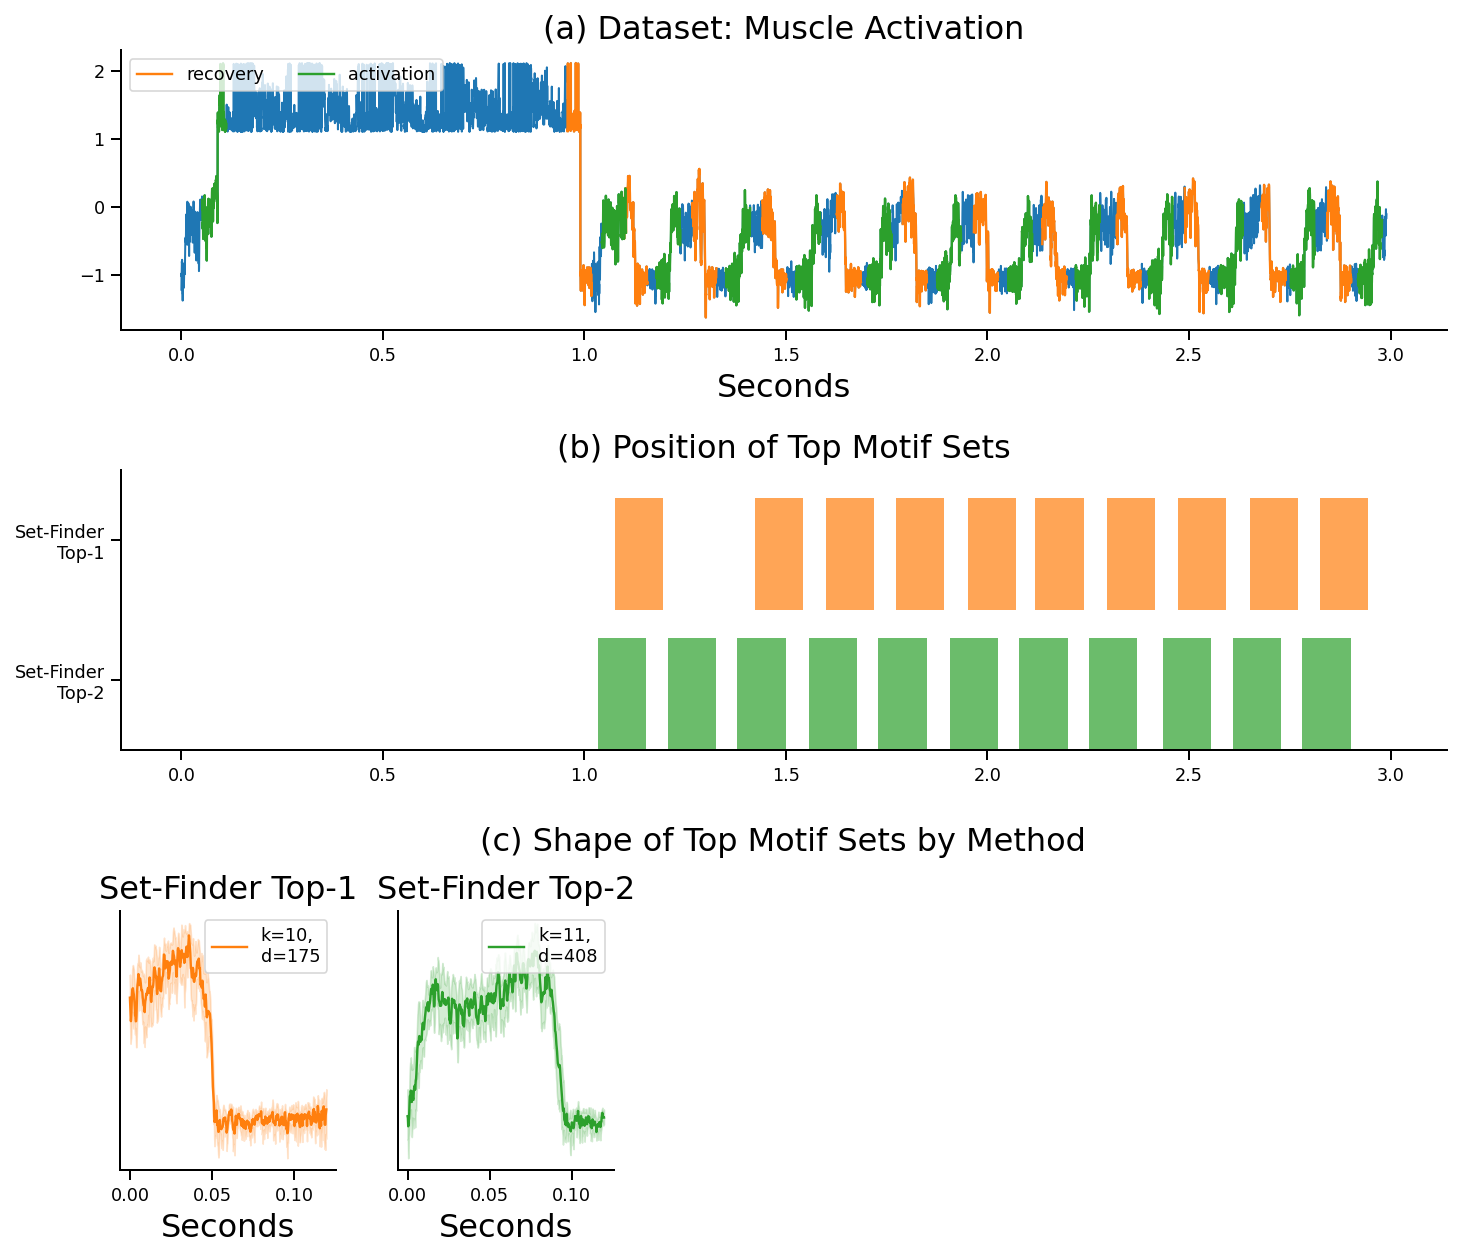

In [10]:
# run jave code first       
ms_set_finder = [   
    [8866, 5374, 7118, 7992, 9759, 10594, 11480, 12361, 13254, 14122],
	[12174, 5163, 6032, 6897, 7784, 8645, 9532, 10395, 11259, 13045, 13905],
]
    
motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, 
                            prefix="Set-Finder", ground_truth=df_gt)

df["Set Finder Top-1"] = [motifset[-1]]
df2["Set Finder Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)


# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [11]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

r: 151.40757751464844 d: 175.3167266845703
r: 204.9344482421875 d: 270.27276611328125
Filtered Elbow Points [0, 1]


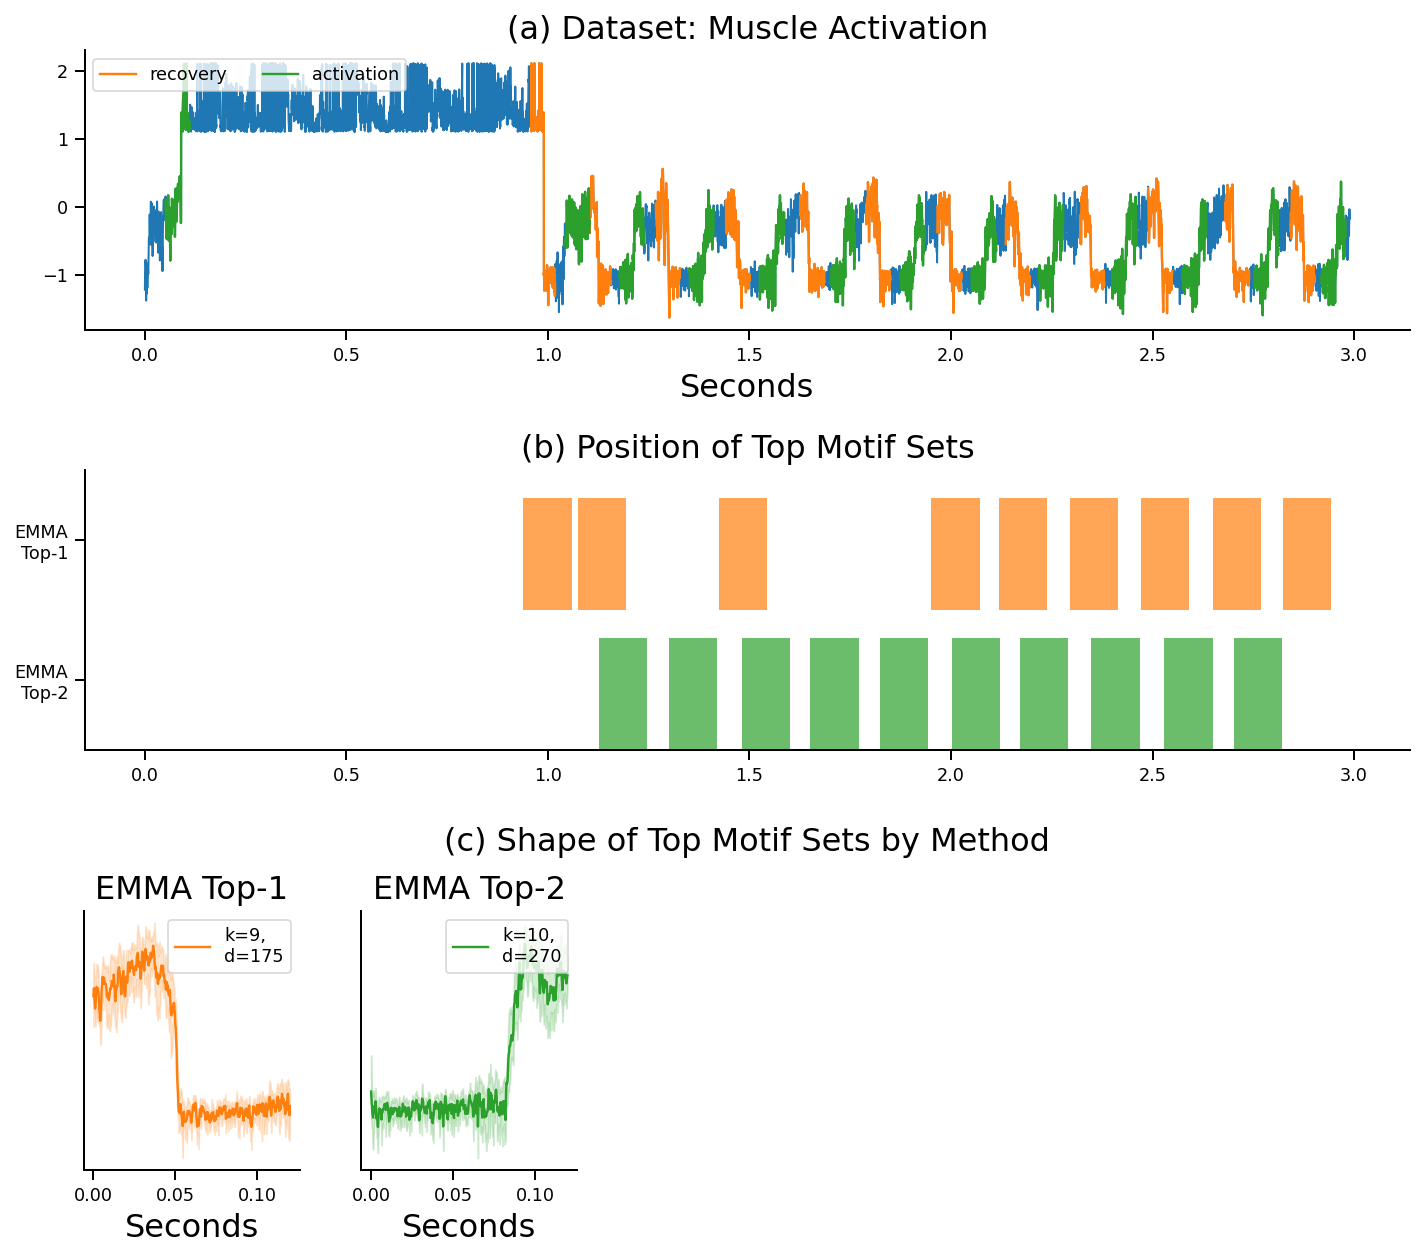

In [12]:
# run jave code first       
ms_emma = [
	[4695, 5372, 7116, 9757, 10592, 11478, 12359, 13252, 14120],
	[5635, 6500, 7410, 8255, 9116, 10008, 10854, 11741, 12648, 13511],
]

motifset = plot_competitors(series, ds_name, ms_emma, 
                            motif_length, prefix="EMMA", ground_truth=df_gt)

df["EMMA Top-1"] = [motifset[-1]]
df2["EMMA Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

r: 100.31826782226562 d: 100.31826782226562
r: 107.18986511230469 d: 133.45394897460938
r: 208.25465393066406 d: 274.7778015136719
Filtered Elbow Points [1, 2]


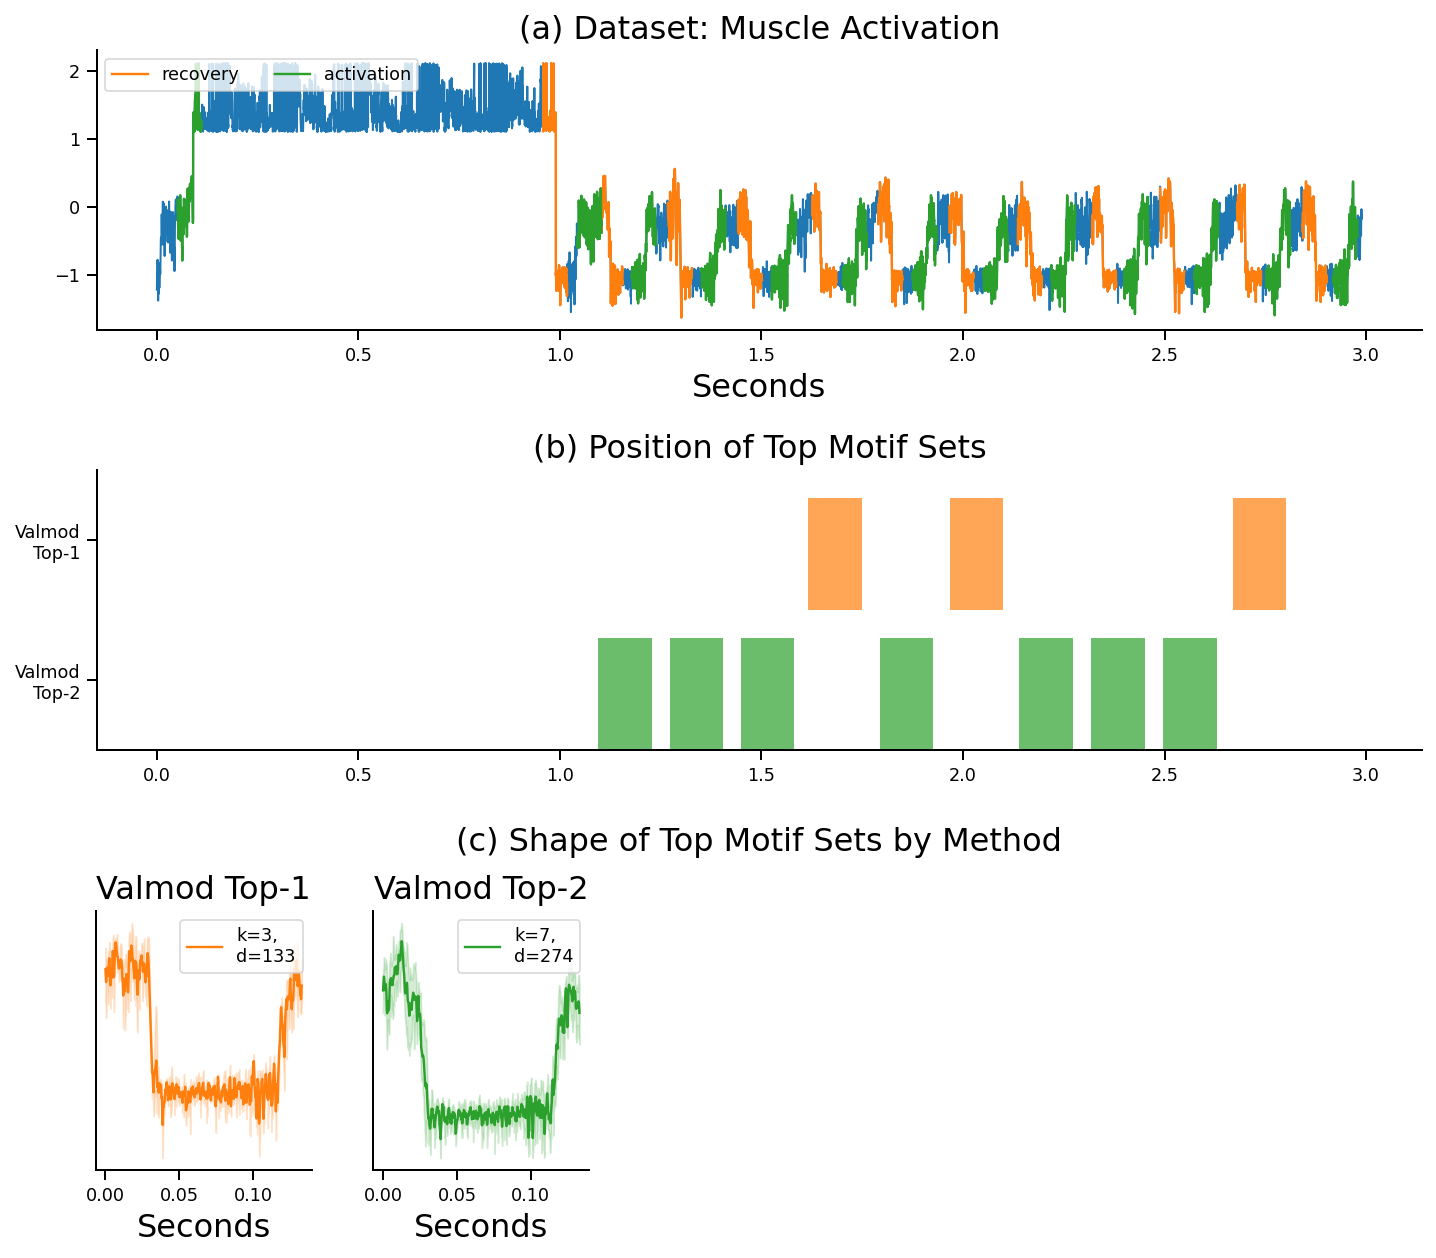

In [13]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs[-1]))
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod", ground_truth=df_gt)

df["VALMOD Top-1"] = [motifset[-1]]
df2["VALMOD Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Learning Motifs
See Java Code

In [14]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs+1)),
       str(mls)])

r: 170.9490203857422 d: 274.0678405761719
Filtered Elbow Points [0]


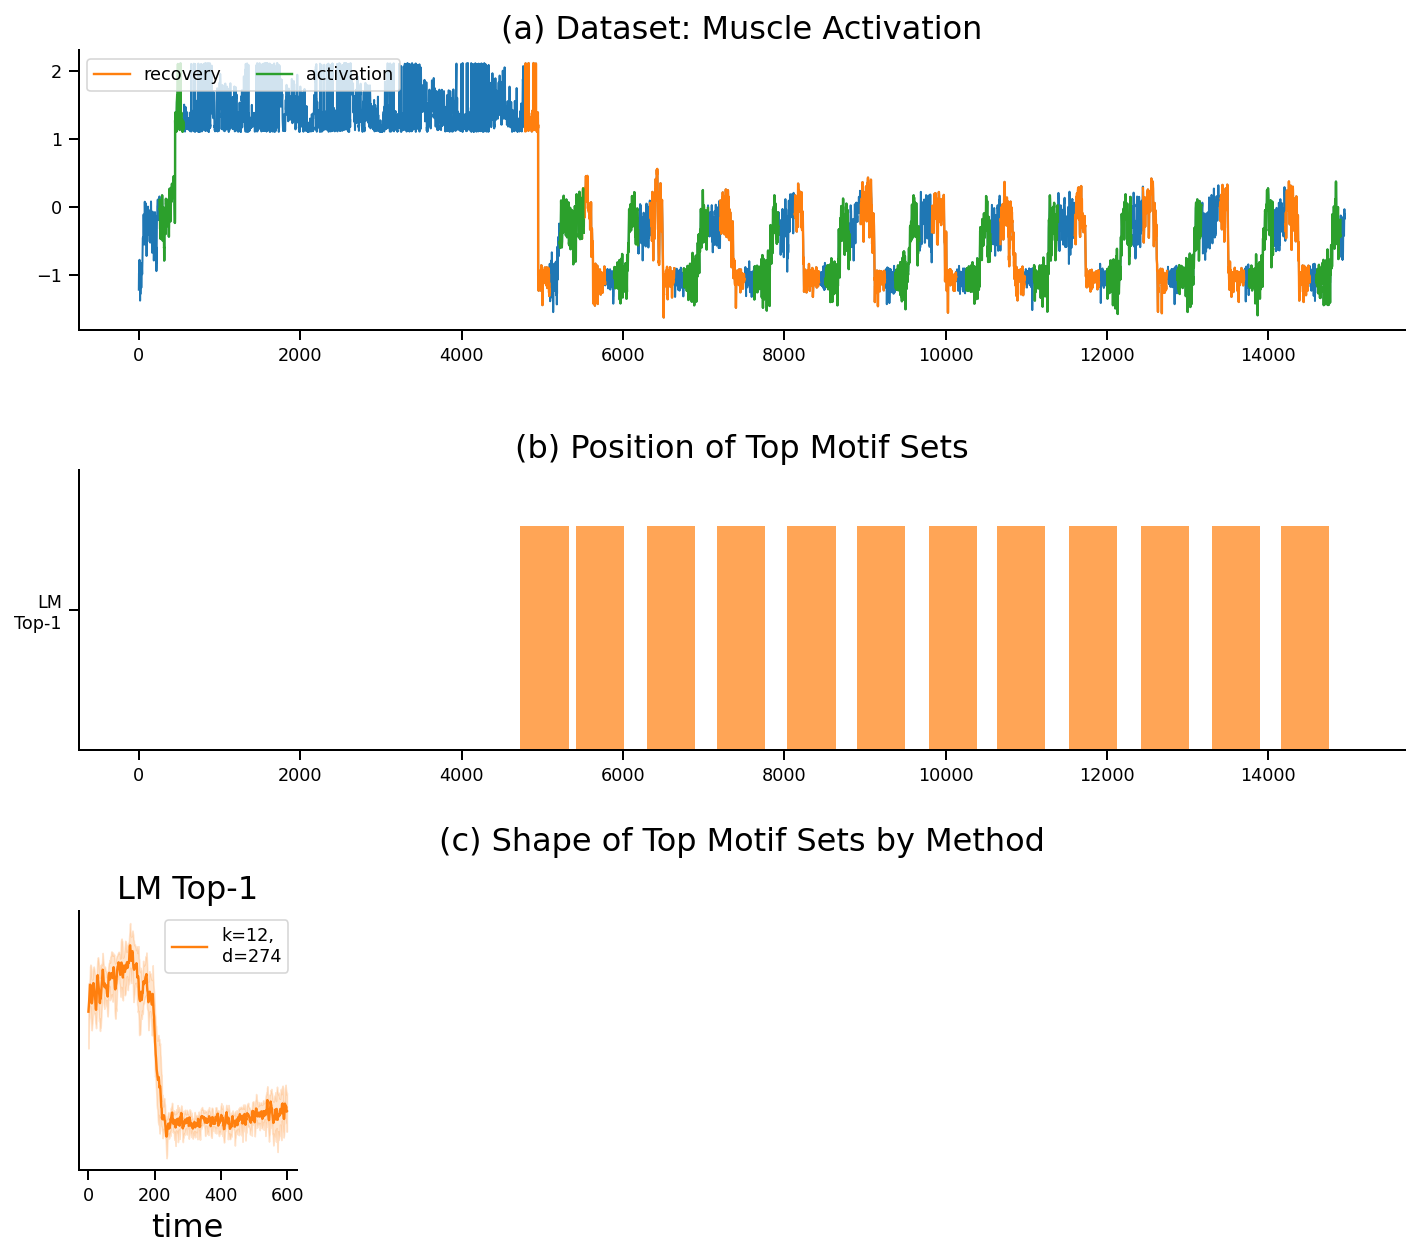

In [16]:
ms_learning_motifs = np.array([
	[4728,5418,6295,7165,8037,8899,9792,10632,11529,12417,13296,14152,],
])
    
motifset = plot_competitors(data, ds_name, ms_learning_motifs, motif_length, 
                 filter=True, prefix="LM", ground_truth=df_gt)

df["LM Top-1"] = [motifset[-1]]
# No second motif df2["LM Top-2"] = [motifset[-2]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [17]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all

,offsets
Motiflets Top-1,"[308, 11133, 13772, 9392, 12017, 8519, 12893, ..."
Set Finder Top-1,"[12174, 5163, 6032, 6897, 7784, 8645, 9532, 10..."
EMMA Top-1,"[5635, 6500, 7410, 8255, 9116, 10008, 10854, 1..."
VALMOD Top-1,"[5478, 6363, 7241, 8966, 10696, 11588, 12486]"
LM Top-1,"[4728, 5418, 6295, 7165, 8037, 8899, 9792, 106..."
Motiflets Top-2,"[6262, 13270, 5396, 8881, 12392, 10602, 8007, ..."
Set Finder Top-2,"[8866, 5374, 7118, 7992, 9759, 10594, 11480, 1..."
EMMA Top-2,"[4695, 5372, 7116, 9757, 10592, 11478, 12359, ..."
VALMOD Top-2,"[8082, 9835, 13346]"


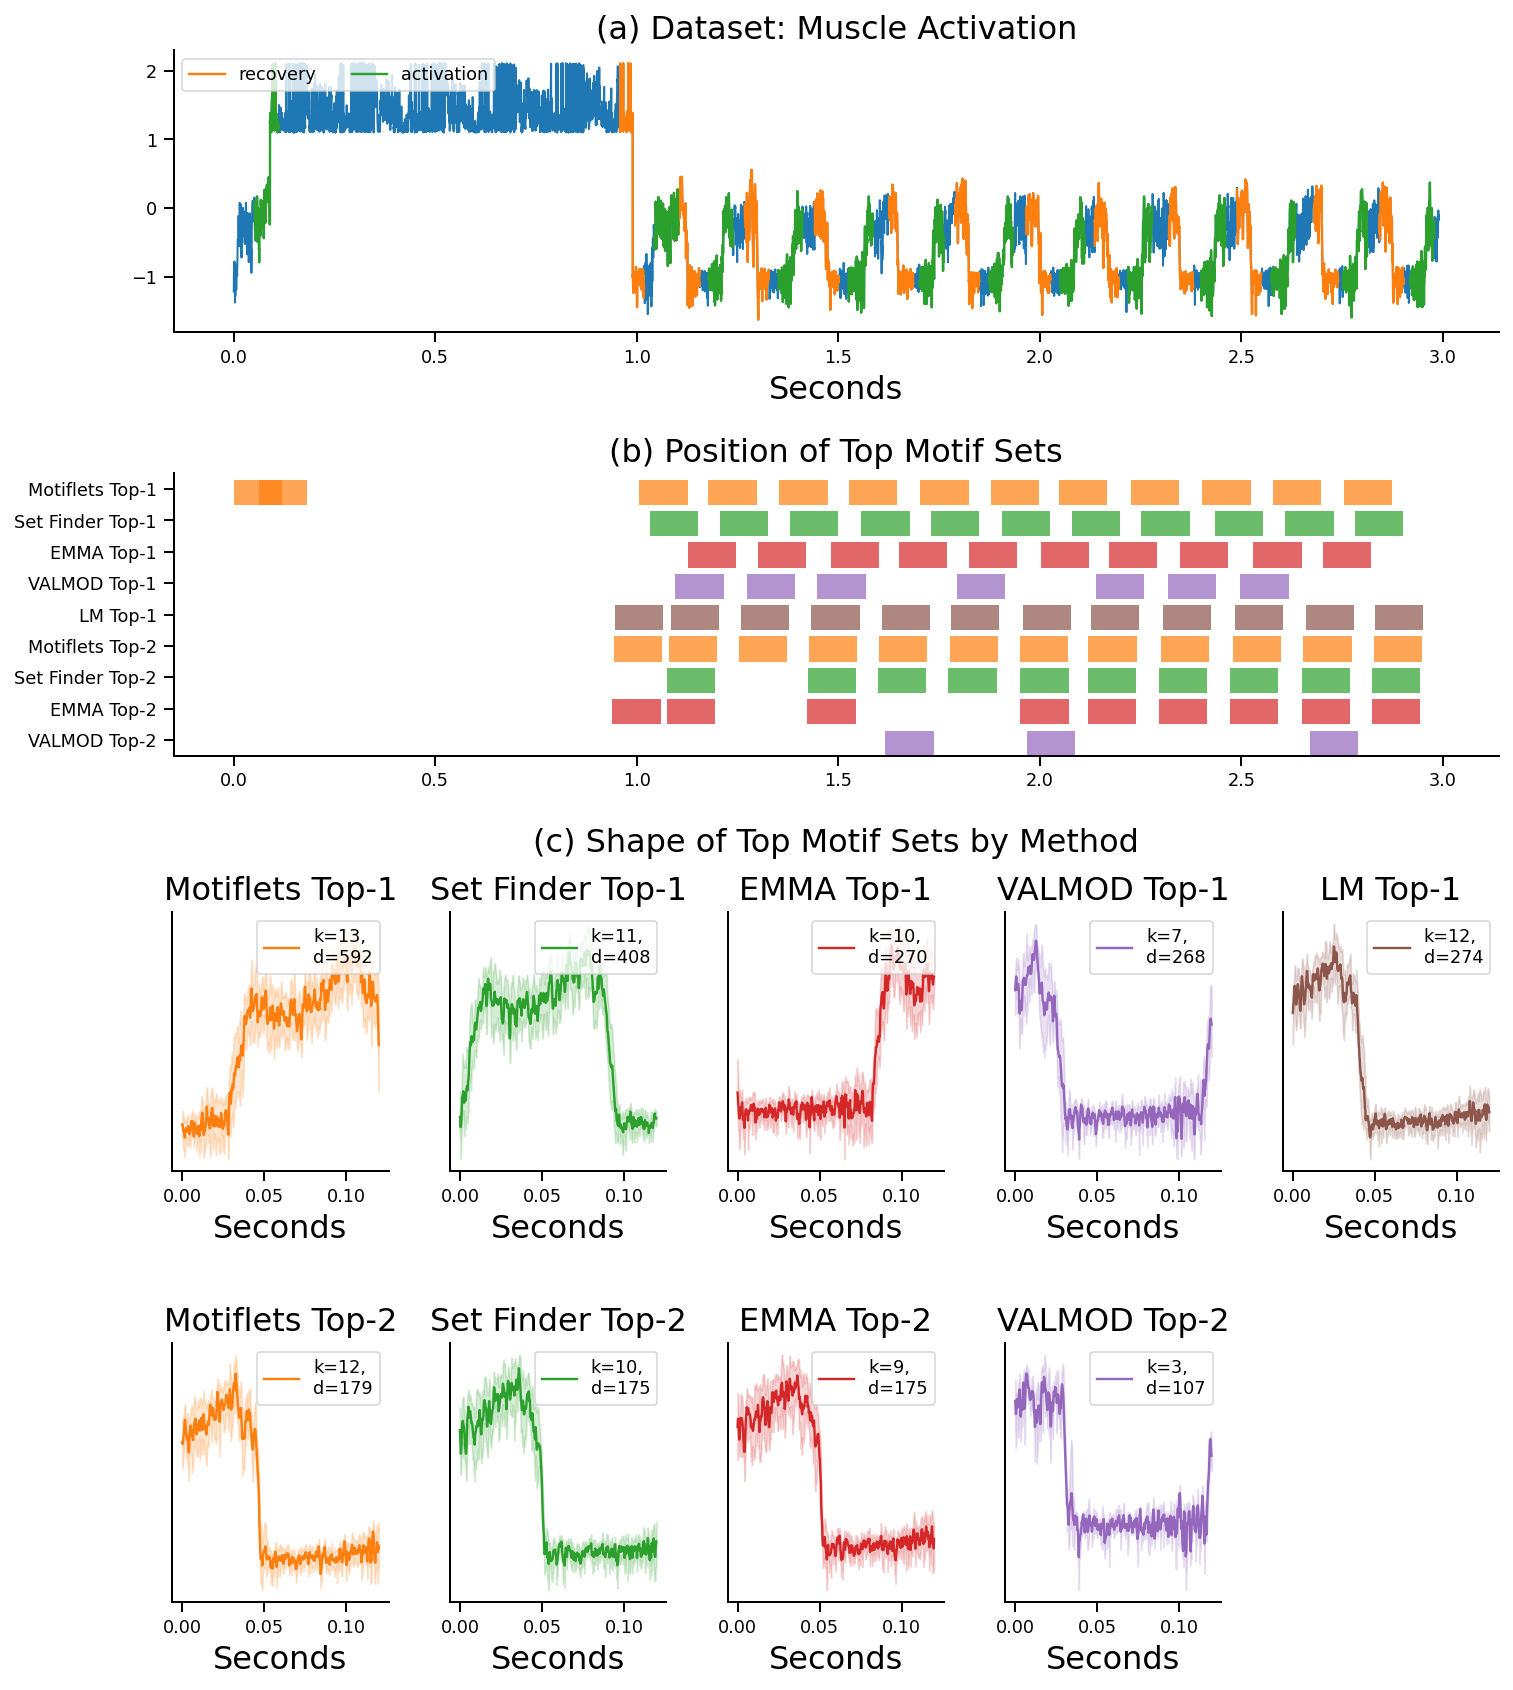

In [18]:
motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values, ground_truth=df_gt)            